In [1]:
import cv2
import os
import numpy as np
import random
from albumentations import Compose, Rotate, HorizontalFlip, RandomBrightnessContrast
import tensorflow as tf
from tensorflow.keras import layers, models

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
lift_dir = '/kaggle/input/shopdataset/Shop DataSet/shop lifters'
non_lift_dir = '/kaggle/input/shopdataset/Shop DataSet/non shop lifters'

In [3]:
# Function to read and resize video frames
def read_and_preprocess_video(video_path, target_size=(224, 224), max_frames=100):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()

    while success and len(frames) < max_frames:
        # Resize frame to the target size
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
        success, frame = cap.read()

    cap.release()

    # If the video has fewer frames than max_frames, pad with black frames
    while len(frames) < max_frames:
        frames.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8))

    # Convert the list of frames to a numpy array
    return np.array(frames)

In [4]:
# Process all videos in the given directory
def process_videos_from_dir(dir_path, label, target_size=(112, 112), max_frames=50):
    videos = []
    labels = []
    
    for video_filename in os.listdir(dir_path):
        video_path = os.path.join(dir_path, video_filename)
        video_frames = read_and_preprocess_video(video_path, target_size, max_frames)
        videos.append(video_frames)
        labels.append(label)
    
    return videos, labels

In [5]:
# Read and process both classes
lift_videos, lift_labels = process_videos_from_dir(lift_dir, label=1)  # Label 1 for 'lifters'
non_lift_videos, non_lift_labels = process_videos_from_dir(non_lift_dir, label=0)  # Label 0 for 'non-lifters'

# Combine the data
all_videos = np.array(lift_videos + non_lift_videos)
all_labels = np.array(lift_labels + non_lift_labels)

In [6]:
# Define augmentations
def augment_video(frames):
    augmentations = Compose([
        Rotate(limit=30, p=0.5),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.3)
    ])
    
    augmented_frames = [augmentations(image=frame)['image'] for frame in frames]
    return np.array(augmented_frames)


In [7]:
# Apply augmentations to the dataset
augmented_videos = [augment_video(video) for video in all_videos]


In [8]:
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv3D(16, (3, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Flatten(),
        layers.Dense(2, activation='softmax')  # 2 classes: lift and non-lift
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Define input shape (frames, height, width, channels)
input_shape = (50, 112, 112, 3)  # 100 frames, 224x224 size, 3 color channels (RGB)
model = create_cnn_model(input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 48, 110, 110,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 24, 55, 55, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 22, 53, 53, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 11, 26, 26, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 237952)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       475,906 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,074 (1.87 MB)

 Trainable params: 491,074 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Convert data to numpy arrays for training
X = np.array(augmented_videos)
y = np.array(all_labels)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Train the model
history = model.fit(X, y, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10


I0000 00:00:1727375995.478652    3487 service.cc:145] XLA service 0x7edd781063b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727375995.478726    3487 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/54 ━━━━━━━━━━━━━━━━━━━━ 6:28 7s/step - accuracy: 0.5000 - loss: 25.2439

I0000 00:00:1727376001.647509    3487 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.5336 - loss: 1095.3414 - val_accuracy: 0.5439 - val_loss: 0.6827
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5888 - loss: 0.6849 - val_accuracy: 0.5789 - val_loss: 0.6734
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5730 - loss: 0.6752 - val_accuracy: 0.6082 - val_loss: 0.6578
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.6302 - loss: 0.6555 - val_accuracy: 0.6140 - val_loss: 0.6378
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.6215 - loss: 0.6401 - val_accuracy: 0.6667 - val_loss: 0.5964
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.6682 - loss: 0.5951 - val_accuracy: 0.6140 - val_loss: 0.6203
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.7024 - loss: 0.5723 - val_accuracy: 0.7310 - val_loss: 0.5130
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.8184 - loss: 0.4360 - val_accuracy: 0.9357 - 

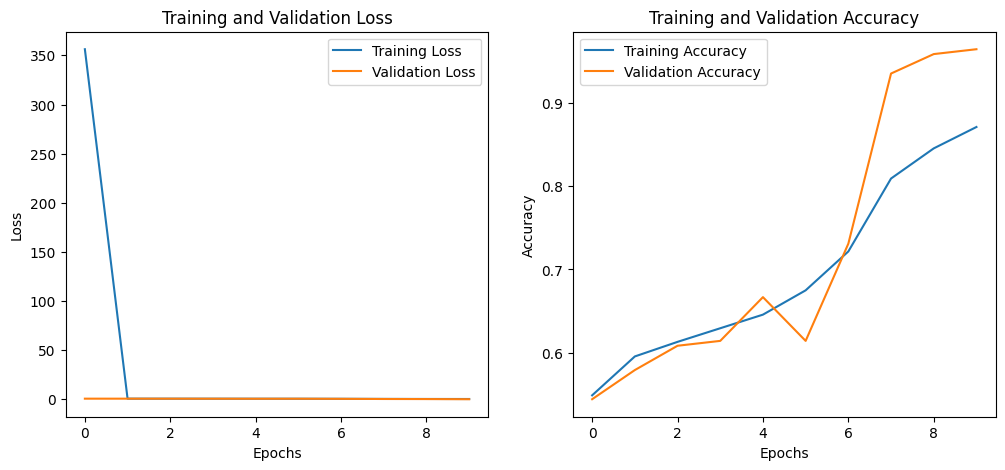

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

loss_acc_metrics_df = pd.DataFrame(history.history)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_acc_metrics_df['loss'], label='Training Loss')
plt.plot(loss_acc_metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loss_acc_metrics_df['accuracy'], label='Training Accuracy')
plt.plot(loss_acc_metrics_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9662 - loss: 0.1175
Test Loss: 0.11566400527954102
Test Accuracy: 0.9649122953414917
